Part 1 : Data Pre-Processing


import basic Libraries

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import training set

In [14]:
actual_training_set = pd.read_csv('data/raspberry_pi_0.csv')

In [15]:

actual_training_set.head()

,Time,CPU_Utilization,RAM_Utilization
0,0,70.267668,71.893365
1,1,73.992046,77.016921
2,2,82.770897,99.895739
3,3,81.537741,94.301333
4,4,82.897394,99.578171


In [16]:

actual_training_set.shape

(1440, 3)


Extract Training Set

In [17]:
training_set=actual_training_set.iloc[:,1:2].values  #:2 making it a matrix

In [18]:

training_set

array([[70.26766837],
       [73.99204587],
       [82.7708967 ],
       ...,
       [88.78732371],
       [97.662709  ],
       [95.67511902]])

In [19]:

training_set.shape


(1440, 1)

The plot of the current Dataset

In [20]:
def plot_me(vector,style=[],lab=[]):
    plt.grid(True)
    
    if len(vector) == len(style) == len(lab):
        for i in range(len(vector)):
            plt.plot(np.arange(len(vector[i])), vector[i], 
                     style[i], label=lab[i])
    else: 
        print('Error : dimention error! ')
    
    plt.legend()
    plt.show()

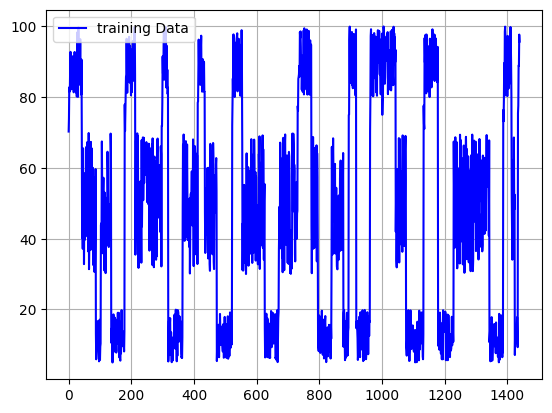

In [21]:

plot_me(vector=[training_set],
        style=['b-'],
        lab=['training Data'])

Feature Scalling

there are two options for feature scalling

    Standardisaton : X_{stand}=\frac{X-\mu_X}{\sigma_X}

Normalization : X_{norm}=\frac{X-Min(X)}{Max(X)-Min(X)}


In [23]:


#Apply Normalization
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set_scalled=sc.fit_transform(training_set)



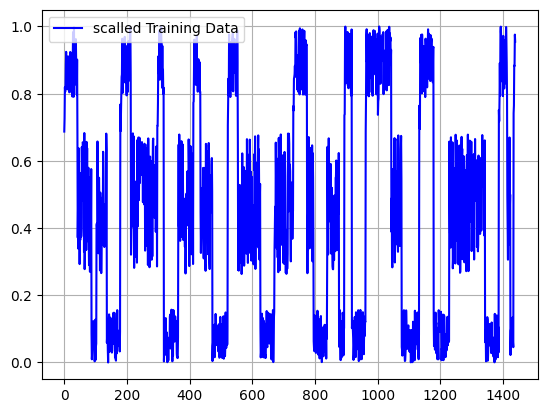

In [24]:


plot_me(vector=[training_set_scalled],
        style=['b-'],
        lab=['scalled Training Data'])




Train-Test Split

if you have stock price in time
, you're predicting stock price at time .

In [25]:


X_train = training_set_scalled[:-1] #all stock price except last 
y_train = training_set_scalled[1:] #stock price shifted by 1




Reshapping

the purpose of reshapping is to change the dimention from 2D to 3D, the 3rd dimention is needed to make it a Tensor as to be compatible with Keras moreover Tensorflow input format. (batch_size, time_step, feature)



X_train_t = np.reshape(X_train, (X_train.shape[0], #obs
                                 X_train.shape[1], #ts
                                 1)                #feature
                      )



In [26]:
X_train_t = np.reshape(X_train, (X_train.shape[0], #obs
                                 X_train.shape[1], #ts
                                 1)                #feature
                      )


In [27]:


X_train_t.shape



(1439, 1, 1)

In [28]:


y_train.shape



(1439, 1)

In [29]:


X_train



array([[0.68722402],
       [0.72645453],
       [0.81892602],
       ...,
       [0.88391743],
       [0.88229969],
       [0.97578803]])

In [30]:
y_train

array([[0.72645453],
       [0.81892602],
       [0.80593665],
       ...,
       [0.88229969],
       [0.97578803],
       [0.95485187]])

Building the RNN


import keras libraries

In [33]:

from keras.models import Sequential 
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import EarlyStopping

2023-09-01 19:56:59.510372: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-01 19:56:59.551570: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-01 19:56:59.552008: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 19:57:00.242373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Initialise Deep Regressor

In [35]:


#init RNN
regressor = Sequential()



Adding Layers

In [36]:
#Adding input layers
regressor.add(LSTM(units = 4, #number of memory units
              activation = 'sigmoid',  #sigmoid
              input_shape = (None, 1)) #(time_step, feature)
             )

#Adding output layer
regressor.add(Dense(units = 1)) #since predicting one value 


Compile The Model

In [37]:


#Compile the model
regressor.compile(optimizer = 'adam', #rmsprop gives same out but more memory
                  loss='mean_squared_error') 



Train the Model

In [38]:


import time



time taken without early stopping : 10.492 secs


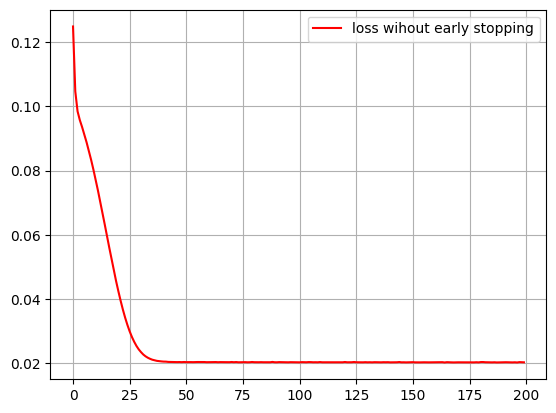

In [39]:


#Train the network
t =time.time()

learn_his = regressor.fit(X_train_t, y_train, batch_size=32, epochs=200, verbose=False)

print(f'time taken without early stopping : {round(time.time()-t,3)} secs')

#plot Loss
plt.grid()
plt.plot(learn_his.history['loss'],'r-',label = 'loss wihout early stopping')
plt.legend()
plt.show()




Speeding up learning process

time taken without early stopping : 0.141 Secs


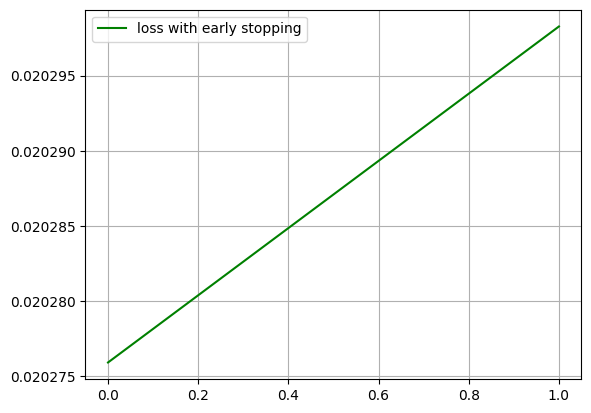

In [40]:
#Train the network
t =time.time()
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=0)

learn_his = regressor.fit(X_train_t, y_train, batch_size=32, epochs=200, verbose=False, callbacks=[early_stop])
print(f'time taken without early stopping : {round(time.time()-t,3)} Secs')

#plot Loss
plt.grid()
plt.plot(learn_his.history['loss'],'g-',label = 'loss with early stopping')
plt.legend()
plt.show()


Part 3 : make Forecast


Build a test Set

In [45]:
#Test Set 
test_set = pd.read_csv('data/raspberry_pi_1.csv')
X_test = test_set.iloc[:,1:2].values

Make Prediction

In [46]:
# Make prediction 
X_test_scalled = sc.transform(X_test)
X_test_t = np.reshape(X_test_scalled, (X_test.shape[0],
                               X_test.shape[1],
                               1)
                     )


Pre-Scalling

In [47]:
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')

ax1.grid()
ax2.grid()

ax1.plot(X_test,'b:o' , label = 'Original Test Data')
ax2.plot(X_test_scalled,'g:*' , label = 'Scalled Trainig Data')

ax1.legend()
ax2.legend()

plt.show()

ValueError: Single argument to subplot must be a three-digit integer, not '211'

<Figure size 640x480 with 0 Axes>

In [48]:
y_pred = regressor.predict(X_test_t)
y_pred_org = sc.inverse_transform(y_pred) # restore original scale 

45/45 [==============================] - 0s 887us/step


Plot the graph

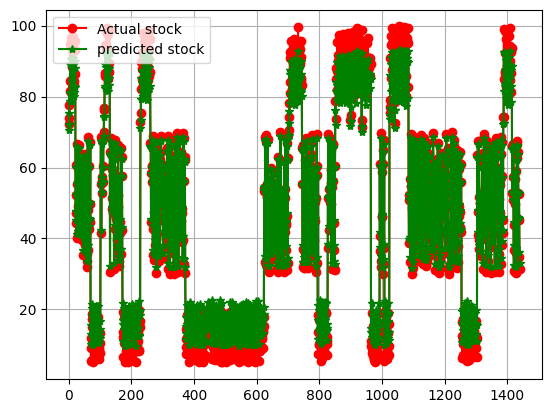

In [49]:


#Plot
plot_me(vector = [X_test,y_pred_org], 
        style = ['r-o','g-*'],
        lab = ['Actual stock','predicted stock'])



In [50]:


from platform import python_version
print(python_version())



3.8.10
